In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wmap_camb_example

data to fit: We want the combined (not binned) version of the spectrum. This gives the measured variance of the sky as a function of multipole l. WMAP does not measure the monopole, and the dipole is set by the motion of the Earth/Milky Way relative to the CMB reference frame. So, the spectrum starts with the quadrupole (l = 2). The first column is the multipole index, the second is the measured power spectrum, and the third is the error in that. For simplicity, we will treat the errors as Gaussian and uncorrelated, though that is not quite accurate. The final two columns break down the error into the instrument noise part and the “cosmic variance” part, due to the fact that we only have a finite number of modes in the sky to measure.

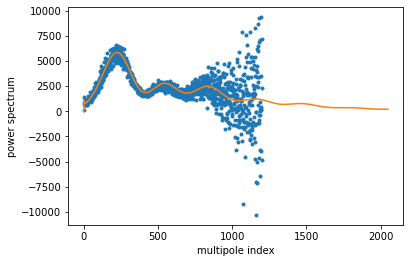

In [2]:
#given code
plt.ion()

#[H_0, w_bh2, w_ch2, tau, A_s, slope]
pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])

#[multipole index, measured power spectrum, error, instrument noise part, “cosmic variance” part]
wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')

plt.clf();
# plt.errorbar(wmap[:,0],wmap[:,1],wmap[:,2],fmt='*', alpha=0.1)
plt.plot(wmap[:,0],wmap[:,1],'.') 

cmb=wmap_camb_example.get_spectrum(pars)

plt.plot(cmb) #what really is the x values here then?
plt.xlabel("multipole index")
plt.ylabel("power spectrum")

plt.show()

### 2) 
Using Gaussian, uncorrelated errors, what do you get for χ2 for the model in my example script, where the Hubble constant H_0 = 65 km/s, the physical baryon density $ω_bh^2=0.02$, the cold dark matter density $ω_ch^2 = 0.1$ the optical depth $τ = 0.05$, the primordial amplitude of fluctuations is $A_s = 2 × 10^{−9}$, and the slope of the primordial power law is 0.96 (where 1 would be scale-invariant). The baryon/dark matter densities are defined relative to the critical density required to close the universe, scaled by h^2 where $h ≡ H_0/100 ∼ 0.7$.   
Note that the universe is assumed to be spatially flat (for reasons too long to justify here), so the dark matter density relative to critical for these parameters would be $1 − (ω_bh^2 + ω_ch^2)/h^2 =71.6%$ for the model assumed here. (You may want to play around plotting different models as you change parameters to get a sense for how the CMB depends on them.)   
If everything has gone well, you should get something around 1588 (please give a few extra digits) for χ2 for this model.

In [3]:
#chi: sum( (data - fitted)^2/data ) or over sigma^2

#assuming Gaussian, uncorrelated errors --> N is diagonal and sigma_i is simple the error on each value

#covarience matrix that we need to use in 5??, just I but with sigma_i^2 ?

# print(len(cmb))
# print(len(wmap[:,1]))

chiSq = 0

#how to actually match up values?
#x is just (1, 2, 3, ...) so this is sorta fine?
for i in range(len(wmap)):
    chiSq +=(wmap[i,1]-cmb[i])**2 / wmap[i,2]**2

print("Chi squared is: {}".format(chiSq)) #hmm not that close

Chi squared is: 1676.467714877247


### 3) 
Keeping the optical depth fixed at 0.05, write a Newton’s method/LevenbergMarquardt minimizer and use it to find the best-fit values for the other parameters, and their errors. What are they?   
If you were to keep the same set of parameter but now float τ, what would you expect the new errors to be? Note that CAMB does not provide derivatives with respect to parameters, so you’ll have to come up with something for that. *Please also provide a plot showing why we should believe your derivative estimates.*

In [89]:
# for derivs, just find slope between points?? yeah i think so
#set up function for each one that takes some tiny steps to get a 'derivative'?

H_0para = 65

# var = np.linspace(0 , H_0para + 10)
var = np.linspace(H_0para - 10 , H_0para + 10, 10)
print(var)

smaller = np.where(var < H_0para)[0][-1]
bigger = np.where(var > H_0para)[0][0]
print(smaller, bigger)

[55.         57.22222222 59.44444444 61.66666667 63.88888889 66.11111111
 68.33333333 70.55555556 72.77777778 75.        ]
4 5


In [90]:
paramArr = [np.asarray([i, 0.02, 0.1, 0.05, 2e-9, 0.96]) for i in var]

#quite slow - this is not going to be efficent
y = [wmap_camb_example.get_spectrum(p, 1820) for p in paramArr]

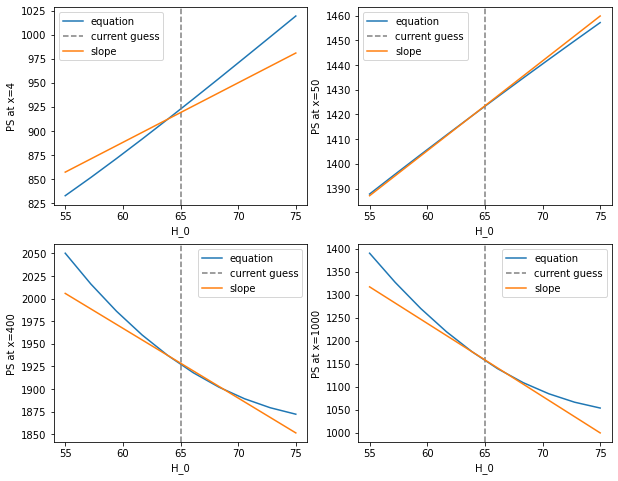

In [142]:
#slope for {0, 1} are bad, the rest look fine
x = 3
ay = np.array(y)

fig, ax = plt.subplots(2, 2, figsize=(10,8))

axs = ax.flatten()

for i, x in enumerate([4, 50, 400, 1000]):

    #mx + b
    b = ay[4,x] - m[x]*var[4]

    #dy/dh_0 = y - y_1 / ( h0 - h0_1)

    #dep on x value
    axs[i].plot(var, ay[:,x], label='equation')
    axs[i].set_xlabel("H_0")
    axs[i].set_ylabel("PS at x={}".format(x))
    axs[i].axvline(H_0para, color='grey', ls="--", label="current guess")
    axs[i].plot(var, m[x]*var + b, label='slope')
    
    axs[i].legend()

plt.show()

In [174]:
def derive(x, params, i, Min, Max, steps):
#     params

    fitP = params[i]

    # var = np.linspace(0 , H_0para + 10)
    var = np.linspace(fitP - Min , fitP + Max, steps)
#     print(var)

    smaller = np.where(var < fitP)[0][-1]
    bigger = np.where(var > fitP)[0][0]
#     print(smaller, bigger, (var[smaller], var[bigger]))
        
    paramArr = [ np.where(params==fitP, v, params) for v in var]

    #quite slow - this is not going to be efficent
    y = np.array([wmap_camb_example.get_spectrum(p, 1820) for p in paramArr])
#     print(y[4])
    
    slope = [(y[bigger,int(j)] - y[smaller,int(j)]) / (var[bigger] - var[smaller]) for j in x]
    
#     print( (y[bigger,50] - y[smaller,50]))
          
#     print(slope)

    return [slope, y, var]

In [183]:
pars_guess=np.asarray([65, 0.02, 0.1, 0.05, 2e-9, 0.96])
x=wmap[:,0]

results = derive(x, pars_guess, 2, 0.05, 0.05, 8)

slope = results[0]
y = results[1]
var = results[2]

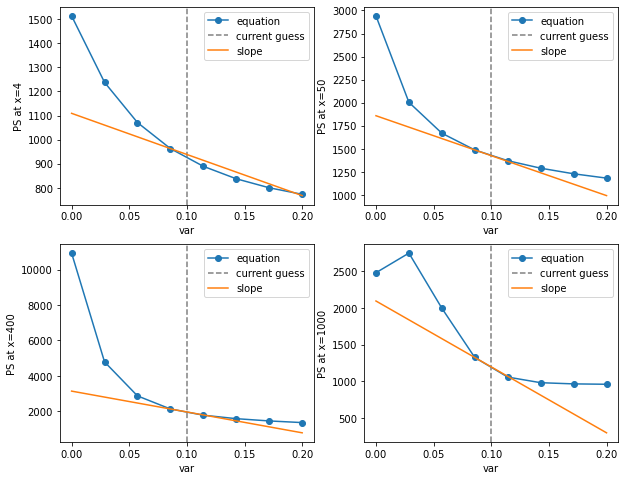

In [185]:
fig, ax = plt.subplots(2, 2, figsize=(10,8))

axs = ax.flatten()
current = pars_guess[2]

for i, x in enumerate([4, 50, 400, 1000]):

    #mx + b
    b = y[3,x] - slope[x]*var[3]

    #dy/dh_0 = y - y_1 / ( h0 - h0_1)

    #dep on x value
    axs[i].plot(var, y[:,x], label='equation', marker="o")
    axs[i].set_xlabel("var")
    axs[i].set_ylabel("PS at x={}".format(x))
    axs[i].axvline(current, color='grey', ls="--", label="current guess")
    axs[i].plot(var, slope[x]*var + b, label='slope')
    
    axs[i].legend()

plt.show()

In [6]:
#class code for straight forwards newton's method
def f(x,params):
    #y=ax^alpha+b
    
    #dy/da=x^alpha
    
    #dy/dalpha=ax^alpha=ae^log(x)*alpha)
    #dy/dalpha=a*log(x)e^log(x)*alpha=a*log(x)*x^alpha
    
    #dy/db=1
    
    a=params[0]
    alpha=params[1]
    b=params[2]
    
    xvec=x**alpha
    y=a*xvec+b
    
    derivs=np.zeros([len(x),len(params)])
    
    derivs[:,0]=xvec
    derivs[:,1]=a*xvec*np.log(x)
    derivs[:,2]=1
    
    return y,derivs

In [7]:
#example code
x=np.linspace(1,10,1801)
a=1
alpha=-1
beta=0.5
pars=np.asarray([a,alpha,beta])

y_true,crap=f(x,pars)
sig=0.2
y=y_true+sig*np.random.randn(len(x))
N=np.eye(len(x))*sig**2
Ninv=np.eye(len(x))/sig**2

pars_guess=np.asarray([1.2,-0.8,0.3])*100
pars_cur=pars_guess.copy()

for iter in range(10):
    y_pred,derivs=f(x,pars_cur)
    resid=y-y_pred #data minus current model
    rhs=derivs.T@(Ninv@resid)
    lhs=derivs.T@Ninv@derivs
    step=np.linalg.inv(lhs)@rhs
    pars_cur=pars_cur+step
    print('iteration ',iter,' has step ',step)
    
    
par_errs=np.sqrt(np.diag(np.linalg.inv(lhs)))
print('final parameters are ',pars_cur,' with errors ',par_errs)

iteration  0  has step  [-119.51145374    1.73521889  -29.24862255]
iteration  1  has step  [-6.63091254e-03  4.18029205e+02 -9.85250988e-05]
iteration  2  has step  [nan nan nan]
iteration  3  has step  [nan nan nan]
iteration  4  has step  [nan nan nan]
iteration  5  has step  [nan nan nan]
iteration  6  has step  [nan nan nan]
iteration  7  has step  [nan nan nan]
iteration  8  has step  [nan nan nan]
iteration  9  has step  [nan nan nan]
final parameters are  [nan nan nan]  with errors  [nan nan nan]


C:\Users\Emma\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in power
  app.launch_new_instance()
C:\Users\Emma\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in matmul
C:\Users\Emma\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in matmul
C:\Users\Emma\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in matmul


In [8]:
def f_cmb(x,params):
    H0=params[0]
    ombh2=params[1]
    omch2=params[2]
#     tau=pars[3]
    As=params[3]
    ns=params[4]
    
    pars = np.insert(params, 2, 0.05)
    
#     y = wmap_camb_example.get_spectrum(pars, lmax=len(x)) #give a length of 1201?
    y = wmap_camb_example.get_spectrum(pars, lmax=len(x))[:-2]
    
    derivs=np.zeros([len(x),len(params)])
    
    derivs[:,0]=1
    derivs[:,1]=1
    derivs[:,2]=1
    derivs[:,3]=1
    derivs[:,4]=1
    
#     [65, 0.02, 0.1, 2e-9, 0.96]
#     derivs[:,0]=derive(x, pars, 0, 10, 10, 8)[0]
#     derivs[:,1]=derive(x, pars, 1, 0.005, 0.005, 8)[0]
#     derivs[:,2]=derive(x, pars, 2, 1, 1, 10)[0]
#     derivs[:,3]=derive(x, pars, 4, 3e-9, 3e-9, 10)[0]
#     derivs[:,4]=derive(x, pars, 5, 1, 1, 10)[0]
    
    
    
    return y,derivs

In [9]:
x=wmap[:,0]

sig=wmap[:,2]
y=wmap[:,1]
N=np.eye(len(x))*sig**2
Ninv=np.eye(len(x))/sig**2

# print(N)

tau = 0.05 #set
#[H_0, w_bh2, w_ch2, _, A_s, slope]
pars_guess=np.asarray([65, 0.02, 0.1, 2e-9, 0.96])

pars_cur=pars_guess.copy()

for iter in range(10):
    y_pred,derivs=f_cmb(x,pars_cur)
    resid=y-y_pred #data minus current model
#     print(resid)
    
    rhs=derivs.T@(Ninv@resid)
    lhs=derivs.T@Ninv@derivs
#     print(rhs, lhs)
    
    step=np.linalg.inv(lhs)@rhs
    
    pars_cur=pars_cur+step
    
    print('iteration ',iter,' has step ',step)
    
    
par_errs=np.sqrt(np.diag(np.linalg.inv(lhs)))
print('final parameters are ',pars_cur,' with errors ',par_errs)

LinAlgError: Singular matrix

### 4) 
Now write a Markov-chain Monte Carlo where you fit the basic 6 parameters, including τ. However, note that we know the optical depth can’t be negative, so you should reject any steps that try to sample a negative τ. What are your parameter limits now? Please also present an argument as to why you think your chains are converged. As a reminder, you can draw samples of correlated data from a covariance matrix with   
r = np.linalg.cholesky(mat);   
d = np.dot(r, np.random.randn(r.shape[0])).    
You will want to use the covariance matrix from part 2) when drawing samples for the MCMC.

### 5) 
The Planck satellite has independently measured the CMB sky, and finds
that the optical depth is 0.0544 ± 0.0073. Run a chain where you add this in as a prior on the value of τ. What are your new parameter values/constraints? You can also take your chain from part 4) and importance sample it (weighting by the prior) with the Planck τ prior. How to those results compare to the full chain results?